In [1]:
import scipy as sc
import numpy as np
from scipy import linalg as LS
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math
import os
%matplotlib notebook
from matplotlib.animation import FuncAnimation

Le but de ce TP est, dans un premier temps, d'étudier numériquement la méthode des éléments finis pour approcher la solution de l'équation de la chaleur. Dans un second temps, on va s'intéresser à un autre type d'approximation de Galerkin, appelée méthode Proper Orthogonal Decomposition (POD), qui est basée sur la décomposition en composantes principales que vous avez étudiée dans le DM préparatoire.

Le but de la première partie du TP est d'implémenter la méthode des éléments finis. Dans la deuxième partie, nous allons étudier l'évolution de l'erreur commise par la méthode des élements finis en fonction de la discrétisation en temps. La troisième partie est consacrée à l'erreur de discrétisation en espace. Enfin, la quatrième partie sera consacrée à l'étude et l'implémentation de la méthode POD.

Remarques générales sur le déroulement du TP: 

*Ecrire vos réponses dans les cellules de texte commençant par REPONSE.
Vous pouvez taper des formules en écrivant du code Latex usuel.

*Pensez-bien à compiler les lignes de codes plt.close() après l'affichage de chaque figure!

*A plusieurs reprises, on vous demande d'indiquer les abscisses, les ordonnées et les labels des courbes affichées. Voir la documentation en ligne de matplotlib pour plus de détails.

*Rendre le fichier .ipynb en l'envoyant à l'adresse e-mail virginie.ehrlacher@enpc.fr pour le 26 mai 2020.

Tout au long de ce TP, nous considèrerons la solution $u(t,x)$ de l'équation de la chaleur sur le domaine $\Omega = (0,1)$ avec un terme source $f\in L^2(]0,T[, L^2(0,1))$ et une condition initiale $g\in L^2(0,1)$. Le temps final est noté $T>0$.

Nous allons choisir ici un terme source $f(t,x)$ de la forme
$$
f(t,x) = r(t) s(x),
$$
avec 
$$
r(t) = 10 \cos(4\pi t)
$$
et 
$$
s(x) = 0.5 - |x-0.5|.
$$
Le temps final est donné par $T=0.5$ et la condition initiale est $g = 0$.

In [2]:
#Temps final
T = 0.5

In [3]:
#Fonction qui renvoie la valeur du terme source f(t,x). 
def r(t) :
    return 10*np.cos(4*math.pi*t)

def s(x): 
    return (0.5- abs(x-0.5))

def f(t,x) : 
    return r(t)*s(x)

In [4]:
#Fonction qui renvoie la valeur de la condition initiale g(x)
def g(x) :
    return 0

# I- Implémentation de la méthode des éléments finis

Dans cette première partie, nous commençons par mettre en oeuvre la méthode des éléments finis $\mathbb{P}_1$ associée à une grille de dsicrétisation uniforme de l'intervalle $(0,1)$ que nous avons vue dans le cours. 

Nous commençons par définir les matrices intervenant dans la discrétisation en espace.

Pour un entier $N_h \in \mathbb{N}^*$, on notera 
$$
\Delta x  = \frac{1}{N_h +1}, \quad x_i = i \Delta x, \quad \forall 0\leq i \leq N_h +1,
$$
$$
\forall 1\leq i \leq N_h, \quad \phi^h_i(x) = \left\{
\begin{array}{ll}
1 - \frac{|x-x_i|}{\Delta x} & \mbox{ si } x\in [x_{i-1}, x_{i+1}],\\
0 & \mbox{sinon.}\\
\end{array}
\right.
$$
On notera également
$$
V_h:= {\rm Vect}\left\{ \phi_1^h, \cdots, \phi_{N_h}^h\right\}
$$
Notez que ${\rm dim}(V_h) = N_h$. On prendra garde à la chose suivante: dans le texte, les fonctions de forme sont numérotées de $i=1$ à $i=N_h$, alors que dans le code, elles sont numérotées de $i=0$ à $i=N_h-1$.

Les matrices $S_h:=\left( S_{h,ij}\right)_{1\leq i,j \leq N_h}$ et $K_h:= \left( K_{h,ij}\right)_{1\leq i,j \leq N_h}$ sont définies telles que pour tout $1\leq i, j \leq N_h$, 
$$
S_{h,ij} = \langle \phi^h_i, \phi^h_j \rangle_{L^2(0,1)} \quad K_{h,ij} = \int_{(0,1)}\frac{d}{dx}\phi^h_i(x)\frac{d}{dx}\phi_j^h(x)\,dx.
$$

1) Vérifier que pour tout $1\leq i\neq j \leq N_h$, 
$$
S_{h,ii} = \frac{2}{3}\Delta x, \quad S_{h,ij} = \frac{1}{6}\Delta x \mbox{ si }j=i+1 \mbox{ ou }j=i-1, \quad S_{h,ij} = 0 \mbox{ sinon}
$$
et 
$$
K_{h,ii} = \frac{2}{\Delta x}, \quad K_{h,ij} = - \frac{1}{\Delta x} \mbox{ si }j=i+1 \mbox{ ou }j=i-1, \quad K_{h,ij} = 0 \mbox{ sinon}.
$$

$\color{blue}{\textrm{REPONSE 1}\\}$

Calcul de $S_{h,ii}$ : 

Pour tout $1\leq i \leq N_h$ :

$\begin{array}{lcl}
S_{h,ii}&=&\int_{(0,1)}(\phi^h_i(x))^2 dx \\
S_{h,ii}&=&\int_{(x_{i-1},x_i)}(1 - \frac{x_i-x}{\Delta x})^2 dx + \int_{(x_{i},x_{i+1})}(1 - \frac{x-x_i}{\Delta x})^2 dx \\
S_{h,ii}&=&[\frac{\Delta_x}{3}(1 - \frac{x_i-x}{\Delta x})^3]_{x_{i-1}}^{x_i}-[\frac{\Delta_x}{3}(1 - \frac{x-x_i}{\Delta x})^3]_{x_{i}}^{x_{i+1}}\\
S_{h,ii}&=&2\frac{\Delta_x}{3}
\end{array}$


Calcul de $S_{h,ij}$ pour j=i+1: 

Pour tout $1\leq i\ \leq N_h-1$ :

$\begin{array}{lcl}
S_{h,ij}&=&\int_{(0,1)}\phi^h_i(x)\phi^h_j(x) dx \\
S_{h,ij}&=&\int_{x_i}^{x_{i+1}}(1 - \frac{x-x_i}{\Delta x})(1 - \frac{x_{i+1}-x}{\Delta x}) dx \\
S_{h,ij}&=&\int_{x_i}^{x_{i+1}}1 + \frac{x_i-x_{i+1}}{\Delta_x}+\frac{-x^2+x(x_{i+1}+x_i)-x_ix_{i+1}}{\Delta_x^2}dx \\
S_{h,ij}&=&\frac{1}{\Delta_x^2}[-\frac{x^3}{3}+\frac{x^2}{2}(x_{i+1}+x_i)-x_ix_{i+1}x]_{x_i}^{x_{i+1}}\\
S_{h,ij}&=&\Delta_x[\frac{i^3-(i+1)^3}{3}+\frac{(i+1)^2-i^2}{2}(2i+1)-i(i+1)]\\
S_{h,ij}&=&\frac{\Delta_x}{6}\\
\end{array}$

Calcul de $S_{h,ij}$ pour j=i-1: 
On suit la même démarche, pour j=i-1 on montre que $S_{h,ij}=\frac{\Delta_x}{6}$

Calcul de $S_{h,ij}$ pour j $\notin [i-1,i+1]$:
Enfin, si j $\notin [i-1,i+1]$, on montre aisément que  $S_{h,ij}=0$.



Calcul de $K_{h,ii}$ : 

Pour tout $1\leq i\ \leq N_h$ :

$\begin{array}{lcl}
K_{h,ii} &=& \int_{(0,1)}(\frac{d}{dx}\phi^h_i(x))^2\,dx. \\
K_{h,ii}&=&\int_{(x_{i-1},x_i)}(\frac{d}{dx}(1 - \frac{x_i-x}{\Delta x}))^2 dx + \int_{(x_{i},x_{i+1})}(\frac{d}{dx}(1 - \frac{x-x_i}{\Delta x}))^2 dx \\
K_{h,ii}&=&\int_{(x_{i-1},x_i)}(\frac{1}{\Delta_x})^2 dx + \int_{(x_{i},x_{i+1})}(\frac{1}{\Delta_x})^2 dx \\
K_{h,ii}&=&\frac{2}{\Delta_x}
\end{array}$

Calcul de $K_{h,ij}$ pour j=i+1 :

Pour tout $1\leq i\ \leq N_h-1$ :

$\begin{array}{lcl}
K_{h,ij} &=& \int_{(0,1)}\frac{d}{dx}\phi^h_i(x)\frac{d}{dx}\phi_{i+1}^h(x)\,dx \\
K_{h,ij} &=& \int_{(x_i,x_{i+1})}\frac{d}{dx}(1 - \frac{x-x_i}{\Delta x})\frac{d}{dx}(1 - \frac{x_{i+1}-x}{\Delta x})\,dx. \\
K_{h,ij} &=&\int_{(x_i,x_{i+1})}-\frac{1}{\Delta_x^2}\\
K_{h,ij} &=&-\frac{1}{\Delta_x}
\end{array}$


Calcul de $K_{h,ij}$ pour j=i-1 :

Pour tout $2\leq i\ \leq N_h$ :

$\begin{array}{lcl}
K_{h,ij} &=& \int_{(0,1)}\frac{d}{dx}\phi^h_i(x)\frac{d}{dx}\phi_{i-1}^h(x)\,dx \\
K_{h,ij} &=& \int_{(x_{i-1},x_i)}\frac{d}{dx}(1 - \frac{x_i-x}{\Delta x})\frac{d}{dx}(1 - \frac{x-x_{i-1}}{\Delta x})\,dx. \\
K_{h,ij} &=&\int_{(x_i,x_{i+1})}-\frac{1}{\Delta_x^2}\\
K_{h,ij} &=&-\frac{1}{\Delta_x}
\end{array}$

Calcul de $K_{h,ij}$ pour j $\notin [i-1,i+1]$:
Enfin, si j $\notin [i-1,i+1]$, on montre aisément que  $K_{h,ij}=0$.


In [5]:
#Définition du pas de discrétisation en espace Deltax en fonction de Nh
def Deltax(Nh):
    return 1.0/(Nh+1)

In [6]:
#Définition de la grille de discrétisation
def xgrid(Nh):
    xvec = np.zeros(Nh)
    for i in range(0,Nh):
        xvec[i]= (i+1)*Deltax(Nh)
    return xvec

In [7]:
#Définition de la matrice Sh en fonction de Nh
def Sh(Nh):
    Sh = np.zeros((Nh, Nh))
    dx = Deltax(Nh)
    for i in range(0,Nh):
        Sh[i,i] = 2.0/3.0*dx
        if (i>0):
            Sh[i-1,i] = 1.0/6.0*dx
        if (i<(Nh-1)):
            Sh[i+1,i] = 1.0/6.0*dx
    return Sh

In [8]:
#Définition de la matrice Kh en fonction de Nh
def Kh(Nh):
    Kh = np.zeros((Nh, Nh))
    dx = Deltax(Nh)
    for i in range(0,Nh):
        Kh[i,i] = 2.0/dx
        if (i>0):
            Kh[i-1,i] = -1.0/dx
        if (i<(Nh-1)):
            Kh[i+1,i] = -1.0/dx
    return Kh

Nous définissons ensuite le vecteur $U_h^0\in \mathbb{R}^{N_h}$ correspondant à la condition initiale. Celui-ci est la solution du problème 
$S_h U_h^0  = G_h$ où $G_h:= \left(\langle g, \phi_i^h \rangle_{L^2(0,1)}\right)_{1\leq i \leq N_h}$ 

2) Montrer que $U_h^0 = 0$.

$\color{blue}{\textrm{REPONSE 2}\\}$

$S_h U_h^0 =0$ car $g=0$

Donc, pour tout $1\leq i\ \leq N_h : (S_h U_h^0)_i=0$.

Montrons que $(U_h^0)_i=0$ pour tout $1\leq i\ \leq N_h$ :

$(S_h U_h^0)_i=\sum_k^{N_h}(S_h)_{ik}(U_h^0)_k = \sum_k^{N_h}\langle \phi^h_i, \phi^h_j \rangle_{L^2(0,1)}(U_h^0)_k $.

On peut écrire ces $N_h$ égalités de la manière suivante : 
$\left\{
\begin{array}{llr}
2 (U_h^0)_1+ (U_h^0)_2 &=&0 \\
 (U_h^0)_1+ 2(U_h^0)_2+(U_h^0)_3 &=&0\\
 \vdots\\
 (U_h^0)_{N_h-2}+ 2(U_h^0)_{N_h-1}+(U_h^0)_{N_h} &=&0\\
 (U_h^0)_{N_h-1}+2(U_h^0)_{N_h}&=&0
\end{array}
\right.$


Une récurrence simple permet de montrer que pour $n \in [1,N_h-1], (U_h^0)_{n}=-\frac{n}{n+1}(U_h^0)_{n+1} $

Si l'on applique cette égalité à la dernière ligne du système suivant, on montre que $(U_h^0)_{N_h}=0$

A l'aide d'un raisonnement en cascade, on montre alors que $(U_h^0)_i=0$ pour tout $1\leq i\ \leq N_h$.

In [9]:
#Définition de la condition initiale U_h(0) en fonction de Nh
def U0h(Nh) :
    return np.zeros(Nh)

Le but des lignes de code ci-dessous est d'afficher la condition initiale.

In [10]:
def plot_condition_initiale(Nh):
    print("Affichage de la fonction U0 initiale")  
    plt.plot(xgrid(Nh), U0h(Nh)) 
    plt.xlabel('$x$')
    plt.ylabel('$u_0(x)$') 
    plt.axis([0, 1, -0.1, 0.1])
    plt.show()

Affichage de la fonction U0 initiale


<IPython.core.display.Javascript object>


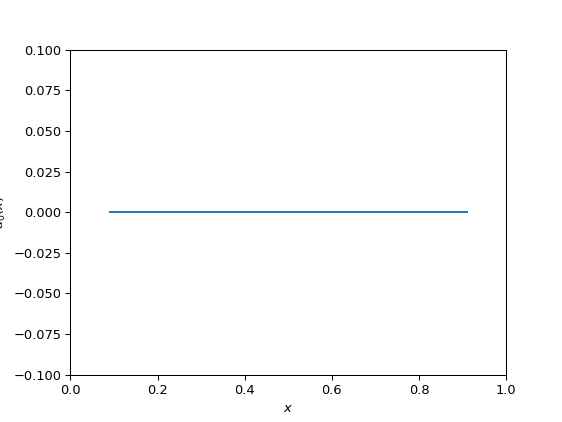

In [11]:
plot_condition_initiale(10)

In [12]:
plt.close()

Les lignes de code suivantes permettent de renvoyer la valeur du vecteur $F_h(t) = (F_{h,i}(t))_{1\leq i \leq N_h}$ où
$$
F_{h,i}(t) = \langle f(t), \phi^h_i\rangle_{L^2(0,1)}.
$$
3) Montrer que comme $f(t,x) = r(t) s(x)$, on a alors 
$$
F_h(t) = r(t) \overline{F}_h
$$
pour un vecteur $\overline{F}_h = (\overline{F}_{h,i})_{1\leq i \leq N_h}$ dont on donnera l'expression en fonction de $s$ et de $\phi_i^h$ pour $1\leq i \leq N_h$.

$\color{blue}{\textrm{REPONSE 3}\\}$

Pour tout $1\leq i\ \leq N_h :$

$\begin{array}{lcl}
F_{h,i}(t) &=& \langle f(t), \phi^h_i\rangle_{L^2(0,1)} \\
F_{h,i}(t) &=&\langle r(t) s(x), \phi^h_i\rangle_{L^2(0,1)} \\
F_{h,i}(t) &=&r(t)\langle s(x), \phi^h_i\rangle_{L^2(0,1)} \\
F_{h,i}(t) &=&r(t)\overline{F}_{h,i}\\
\end{array}$

avec pour tout $1\leq i\ \leq N_h, \quad \overline{F}_{h,i}=\langle s(x), \phi^h_i\rangle_{L^2(0,1)}$

In [13]:
#Fonction qui renvoie la valeur du vecteur Fh(t)
def Fbarh(Nh): 
    Fh= np.zeros(Nh)
    for i in range(0,Nh): 
        Fh[i] = s(xgrid(Nh)[i])
        
    Gh = np.dot(Sh(Nh),Fh)
    return Gh
    

def Fh(t,Nh):
    return r(t)*Fbarh(Nh)

Nous introduisons ensuite les différents paramètres de discrétisation en temps, en particulier le pas de temps 
$$
\Delta t = T/P
$$
avec $P\in \mathbb{N}^*$ un entier.

In [14]:
#Fonction qui renvoie la valeur du pas de temps Deltat en fonction de l'entier P
def Deltat(P) :
    return T/P

Le but des lignes de code suivantes est de montrer une animation illustrant l'évolution du terme source $f(t,x)$ au cours du temps. Faire tourner le code pour visualiser l'évolution de $f$.

In [15]:
## Le but de cette fonction est d'afficher l'évolution de f(t,x) au cours du temps
Nhplot = 21
Pplot = 50
Fplot = np.zeros((Nhplot,Pplot+1))

xplot = xgrid(Nhplot)
dtplot = Deltat(Pplot)
for p in range(0,Pplot+1):
    for i in range(0,Nhplot):
        Fplot[i,p]= f(p*dtplot, xplot[i])
        
fig1, ax1 = plt.subplots(1, figsize = (6,6))
plotf,  = ax1.plot(xplot,Fplot[:,0])

def animate(p):
    f = Fplot[:,p]
    plotf.set_ydata(f)    
    
def init(): 
    ax1.set_xlim(0,1)
    ax1.set_ylim(-6,6)
    return plotf,

step = 1
steps = np.arange(1,Pplot,step)
ani = FuncAnimation(fig1, animate,steps, init_func = init, interval = 100, blit = True)

<IPython.core.display.Javascript object>

In [16]:
plt.close()

Nous définissons ensuite une fonction qui permet de résoudre l'équation de la chaleur, avec une discrétisation en espace caractérisée par un entier $N_h$, une discrétisation en temps caractérisée par un entier $P$, et à l'aide d'un $\theta$-schéma caractérisé par un réel $\theta\in [0,1]$. 

4) Remplir les lignes de code correspondantes pour implémenter un theta-schéma pour résoudre l'équation de la chaleur pour un pas de temps $\Delta t = \frac{T}{P}$ et un pas d'espace d'espace $\Delta x = \frac{1}{N_h +1}$. 
Les solutions aux différents pas de temps sont stockées dans une matrice $W\in \mathbb{R}^{N_h \times (P+1)}$ telle que $W_{i,p}  = U_{h,i}^p$.

$\color{blue}{\textrm{REPONSE 4}\\}$

Expression de A et B dans le code ci-dessous.

In [17]:
# Résolution de l'équation de la chaleur par la méthode des éléments finis avec un theta-schéma
def sol_chaleur(Nh, P, theta):
    dt = Deltat(P)
    S = Sh(Nh)
    K = Kh(Nh)

    W = np.zeros((Nh,P+1));
    Uold = U0h(Nh)
    W[:,0] = Uold;
    
    ## Uold représente U^p
    ## Unew représente U^{p+1}
    for p in range(0,P):
        
        B = np.dot((S-(1-theta)*dt*K),Uold)+dt*(theta*Fh((p+1)*dt,Nh)+(1-theta)*Fh(p*dt,Nh))
        A = S+theta*dt*K
 
        Unew = LA.solve(A,B) ## Calcul la solution du problème A^{-1}B
        W[:,p+1] = Unew 
        Uold = Unew
        
    return W

Nous allons maintenant tester cette fonction avec des valeurs tests, à savoir $N_{h,try} = 50$, $P_{try}= 500$ et 
$\theta_{try}= 1$ (ce qui correspond à un schéma d'Euler implicite). Le code peut prendre quelques secondes à tourner.

In [18]:
Ptry = 50
Nhtry = 21
thetatry = 1

Wtry = sol_chaleur(Nhtry, Ptry,thetatry)

Les lignes de code suivantes permettent de voir l'évolution de la solution obtenue.

In [19]:
fig2, ax2 = plt.subplots(1, figsize = (6,6))
xtry = xgrid(Nhtry)
plotu,  = ax2.plot(xtry,Wtry[:,0])

def animate2(p):
    f = Wtry[:,p]
    plotu.set_ydata(f)    
    
def init2(): 
    ax2.set_xlim(0,1)
    ax2.set_ylim(-0.3,0.3)
    return plotu,

step = 1
steps = np.arange(1,Ptry,step)
ani = FuncAnimation(fig2, animate2,steps, init_func = init2, interval = 100, blit = True)

<IPython.core.display.Javascript object>

In [20]:
plt.close()

5) Qu'observez-vous quant à la régularité de la solution $u$ en $x$ (en comparaison de la régularité du terme source $f$ en $x$)?  

$\color{blue}{\textrm{REPONSE 5}\\}$
On observe que la solution $u$ en $x$ est beaucoup plus régulière que le terme source $f$ en $x$. Le point anguleux est lissé, il n'y a pas de discontinuité dans la solution. 


# II- Etude de l'évolution de l'erreur en fonction de la discrétisation en temps

Le but de cette partie est d'étudier l'influence du pas de temps $\Delta t$ sur l'erreur d'approximation donnée par ce schéma, pour une valeur de discrétisation en espace $N_h$ fixée.

In [21]:
#Valeur de Nh fixée dans cette partie
Nh = 31

Nous allons tout d'abord étudier la stabilité du schéma en temps, en fonction de la valeur de $\theta$ et du pas de temps $\Delta t$. Les lignes de code ci-dessous permettent de calculer la solution de l'équation de la chaleur pour différentes valeurs de $P$ (i.e. de $\Delta t$) et de $\theta$. 

1) Faites tourner les lignes de code contenues dans les deux cellules ci-dessous pour calculer et visualiser l'évolution de la solution approchée pour les valeurs de $\theta = 1$ (schéma implicite) puis $0.5$ (schéma de Cranck-Nicholson) puis $0$ (schéma explicite). Que constatez-vous?

$\color{blue}{\textrm{REPONSE 1}\\}$

Pour le schéma implicite et le schéma de Cranck-Nicholson, la solution approchée est bien régulière. Le comportement de la solution pour ces deux schéma semble par ailleurs similaire.

En revanche, pour le schéma explicite on observe un comportement singulier. La forme de la solution est très différente des formes rencontrées précédemment. La condition de stabilité pour le schéma explicite n'est certainement pas vérifiée. 

In [22]:
# Paramètres de discrétisation en temps
P = 3049
theta = 0

W = sol_chaleur(Nh, P,theta)

In [23]:
fig3, ax3 = plt.subplots(1, figsize = (6,6))
xvec = xgrid(Nh)
plotu,  = ax3.plot(xvec,W[:,0])

def animate3(p):
    f = W[:,p]
    plotu.set_ydata(f)    
    
def init3(): 
    ax3.set_xlim(0,1)
    ax3.set_ylim(-0.3,0.3)
    return plotu,

step = 1
steps = np.arange(1,P,step)
ani = FuncAnimation(fig3, animate3,steps, init_func = init3, interval = 10, blit = True)

<IPython.core.display.Javascript object>

In [24]:
plt.close()

Nous allons maintenant calculer les valeurs propres de la matrice $C := S_h^{-1/2} K_h S_h^{1/2}$. 

2) Remplir les lignes de code correspondantes dans la cellule ci-dessous. Quelle est la valeur de la plus grande valeur propre de cette matrice? 

$\color{blue}{\textrm{REPONSE 2}\\}$
La valeur de la plus grande valeur propre de cette matrice est environ égale à 12199.

In [26]:
S = Sh(Nh)
K = Kh(Nh)

#On calcule tout d'abord la racine carrée de la matrice Sh, puis son inverse
Racine = LS.sqrtm(S)
invRacine = LA.inv(Racine)

C1=np.dot(invRacine, K)
C=np.dot(C1,invRacine)

#print(C)
vals, vecs = LA.eigh(C)
print(np.max(vals))

12199.670214084039


3) En déduire la valeur de $P$ la plus petite possible pour que le schéma d'Euler explicite soit stable.

$\color{blue}{\textrm{REPONSE 3}\\}$ 
Le schéma d'Euler explicite est stable sous la condition : 
$\begin{equation}
max \lambda_i \Delta_t \leq 2
\end{equation}$

$\begin{array}{lcl}
max \lambda_i \Delta_t \leq 2&\Leftrightarrow&max \lambda_i \frac{T}{P} \leq 2\\
&\Leftrightarrow& \frac{max \lambda_i T}{2}\leq P \\
&\Leftrightarrow& \frac{12199.670214084039}{4}\leq P \\
&\Leftrightarrow& 3050\leq P
\end{array}$

On peut vérifier ce résultat en affichant la solution du schéma d'Euler explicite dans le cas où la condition de stabilité n'est pas respectée. On observe bien un comportement chaotique de la solution.


4) Faire maintenant varier la valeur de $N_h$ ci-dessus et observez comment la plus grande valeur propre de la matrice $S_h^{-1/2}K_h S_h^{-1/2}$ évolue en fonction de $N_h$. Que constatez-vous?

In [27]:
P = 500
theta = 0
list_Nh=np.arange(10,101,1)
list_max_eigen_value=[]
list_P_min=[]
for Nh in list_Nh:
    S = Sh(Nh)
    K = Kh(Nh)
    Racine = LS.sqrtm(S)
    invRacine = LA.inv(Racine)
    C1=np.dot(invRacine, K)
    C=np.dot(C1,invRacine)
    vals, vecs = LA.eigh(C)
    list_max_eigen_value.append(max(vals))
    P_min=max(vals)*T/2
    list_P_min.append(P_min)

plt.plot(list_Nh,list_max_eigen_value, label="maximum eigen value of C")
plt.plot(list_Nh,list_P_min, label="minimum value of P for the Euler explicit method")
plt.xlabel("Nh")
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>

In [28]:
plt.close()

$\color{blue}{\textrm{REPONSE 4}\\}$ 

La plus grande valeur propre de la matrice $S_h^{-1/2}K_h S_h^{-1/2}$ et la valeur minimale de P assurant la stabilité du schéma d'Euler augmentent fortement en fonction de $N_h$. 

Dans la suite du TP, nous allons étudier comment l'erreur d'approximation évolue en fonction du pas de temps $\Delta t$ pour une valeur de discrétisation spatiale fixée pour le schéma d'Euler implicite et le schéma de Cranck-Nicholson. Pour ce faire, nous allons fixer la valeur de $N_h$.

In [29]:
#Valeur de Nh fixée dans cette partie 
Nh = 31

Pour calculer ces erreurs, nous avons besoin de calculer une solution de référence. Comme on ne dispose pas de la solution exacte, la solution de référence est ici la solution numérique calculée pour une valeur $P_{ref}$ très grande. On supposera que celle-ci fournit une approximation suffisamment précise de la solution exacte. Ensuite, nous calculerons les erreurs entre cette solution numérique de référence et la solution obtenue pour des valeurs de $P$ beaucoup plus petites que $P_{ref}$. 

Nous commençons par fixer une très grande valeur $P_{ref}$ de référence et nous calculons la solution de référence associée avec un schéma de Cranck-Nicholson. Nous allons supposer que cette solution est suffisamment proche de la solution exacte de l'équation de la chaleur pour pouvoir la comparer à d'autres solutions. Ce calcul peut prendre quelques minutes. On notera également
$$
\Delta t_{ref}:= \frac{T}{P_{ref}}.
$$

In [30]:
Pref = 2048
Wref = sol_chaleur(Nh,Pref,0.5)

Nous allons comparer cette solution de référence avec des solutions obtenues pour des valeurs de $P$ telles que 
$$
P_{ref} = m P.
$$
avec $m\in \mathbb{N}^*$. 

Dans toute la suite, nous noterons, pour tout $P\in \mathbb{N}^*$, et pour tout $0\leq p \leq P$, 
$$
u_{h,P}^p:= \sum_{i=1}^{N_h} U_{h,P,i}^p \phi_i^h,
$$
où $\left( U_{h,P}^p\right)_{0\leq p \leq P}$ est la solution donnée par le schéma numérique considéré pour un pas de temps $\Delta t = \frac{T}{P}$ et où pour tout $0\leq p\leq P$, $U_{h,P}^p:= \left( U_{h,P,i}^p\right)_{1\leq i \leq N_h}$. La fonction $u_{h,P}^p$ est donc une approximation après discrétisation en temps de la solution $u_h(t^P_p)$ où $[0,T] \ni t \mapsto u_h(t)$ est la solution en temps continu de l'approximation de Galerkin de l'équation de la chaleur obtenue avec l'espace de discrétisation $V_h$, et où $t^P_p := p\Delta t= p\frac{T}{P}$.

5) Montrer que pour tout $1\leq p \leq P$, on a 
$$
t^P_p = mp \Delta t_{ref} = t^{P_{ref}}_{mp}.
$$

$\color{blue}{\textrm{REPONSE 5}\\}$ 
$\begin{equation}t^P_p  =p\frac{T}{P} = p\frac{P_{ref}\Delta t_{ref} }{P}= mp \Delta t_{ref} =t^{P_{ref}}_{mp}. \end{equation}$

Nous allons calculer l'erreur
$$
\max_{0\leq p \leq P} \| u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}.
$$
Notez que $u_{h,P}^p$ et $u_{h,P_{ref}}^{mp}$, d'après les questions précédentes, sont deux approximations de $u_h(t_p^P)$.

6) Montrer que 
$$
\|u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}^2 = (U_{h,P}^p - U_{h, P_{ref}}^{mp})^T S_h (U_{h,P}^p - U_{h, P_{ref}}^{mp}).
$$

$\color{blue}{\textrm{REPONSE 6}\\}$ 

$\begin{array}{lcl}
\|u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}^2 &=&\langle \sum_{i=1}^{N_h} (U_{h,P,i}^p-U_{h,P_{ref},i}^{mp}) \phi_i^h, \sum_{j=1}^{N_h} (U_{h,P,j}^p-U_{h,P_{ref},j}^{mp}) \phi_i^h \rangle_{L^2(0,1)}\\
\|u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}^2 &=& \sum_{i=1}^{N_h}\sum_{j=1}^{N_h} (U_{h,P,i}^p-U_{h,P_{ref},i}^{mp}) \langle \phi_i^h, \phi_j^h \rangle (U_{h,P,j}^p-U_{h,P_{ref},j}^{mp}) \\
\|u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}^2 &=& \sum_{i=1}^{N_h}\sum_{j=1}^{N_h} (U_{h,P,i}^p-U_{h,P_{ref},i}^{mp}) (S_h)_{ij}(U_{h,P,j}^p-U_{h,P_{ref},j}^{mp}) \\
\|u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}^2 &=&(U_{h,P}^p - U_{h, P_{ref}}^{mp})^T S_h (U_{h,P}^p - U_{h, P_{ref}}^{mp})
\end{array}$

Remplir les lignes de code ci-dessous pour pouvoir calculer $$
\max_{0\leq p \leq P} \| u_{h,P}^p - u_{h,P_{ref}}^{mp}\|_{L^2(0,1)}
$$ pour un schéma d'Euler implicite et pour un schéma de Cranck-Nicholson. 

In [31]:
#Tableau contenant les différentes valeurs de P pour lesquelles nous allons calculer les erreurs. 
Ptab = [2,4,8,16,32,64,128]

#Tableaux vides qui vont contenir les valeurs des différentes erreurs pour le schéma d'Euler implicite et le schéma de Cranck-Nicholson. 
errtab_imp = []
errtab_CN = []

for P in Ptab:
    m = int(Pref/P)
    W_imp = sol_chaleur(Nh,P,1) ##Contient la solution de l'équation de la chaleur par un schéma implicite avec \Delta t = T/P
    W_CN = sol_chaleur(Nh,P,0.5) ##Contient la solution de l'équation de la chaleur par un schéma de Cranck-Nicholson avec \Delta t = T/P
    
    err_max_imp = 0;
    for p in range(1,P+1):
        time = p*m
        
        Usol_ref = Wref[:,time] ## contient le vecteur des coordonnées de u_{h, P_{ref}}^{mp}
        Usol_app = W_imp[:,p] ## contient le vecteur des coordonnées de u_{h, P}^{p} avec le schéma implicite
        
        # err = \| u_{h, P}^{p} -  u_{h, P_{ref}}^{mp} \|_{L^2(0,1)}
        err =np.dot(np.dot((Usol_ref-Usol_app).T,Sh(Nh)),(Usol_ref-Usol_app))
        err_max_imp = max(err_max_imp, err);
        
    errtab_imp.append(err_max_imp)
    
    err_max_CN = 0;
    for p in range(1,P+1):
        time = p*m
        
        Usol_ref = Wref[:,time]  ## contient le vecteur des coordonnées de u_{h, P_{ref}}^{mp}
        Usol_app= W_CN[:,p] ## contient le vecteur des coordonnées de u_{h, P}^{p} avec le schéma de Cranck-Nicholson
        
         # err = \| u_{h, P}^{p} -  u_{h, P_{ref}}^{mp} \|_{L^2(0,1)}
        err =np.dot(np.dot((Usol_ref-Usol_app).T,Sh(Nh)),(Usol_ref-Usol_app))
        err_max_CN = max(err_max_CN, err);
        
    errtab_CN.append(err_max_CN)

Les lignes de code ci-dessous permettent de tracer ces erreurs en échelle logarithmique en fonction de $P$ pour les deux types de schémas. 

Compléter ces lignes de code pour afficher les abscisses, les ordonnées et les labels des différentes courbes tracées. 

In [42]:
plt.loglog(Ptab,errtab_imp,label="Error, Euleur explicit method", marker='x')
plt.loglog(Ptab,errtab_CN,label="Error, Cranck-Nicholson method", marker='x')
plt.grid()
plt.xlabel("P")
plt.ylabel("max error")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [43]:
plt.close()

7) Quelles sont les vitesses de convergence de ces erreurs pour ces deux schémas en fonction de $\Delta t$? (Faire une régression linéaire si besoin). 

In [44]:
#Regression linéaire pour le schéma d'Euler explicite
#On retire les premiers points car ils ne suivent pas la tendance globale de la courbe.
reg_imp=np.polyfit(np.log10(Ptab[1:]),np.log10(errtab_imp[1:]),1,rcond=False, full=True)
alpha_imp=reg_imp[0][0]
beta_imp=reg_imp[0][1]
residuals_imp=reg_imp[1][0]
print("alpha_imp=",alpha_imp)
print("beta_imp=",beta_imp)
print("residuals_imp",residuals_imp,'\n')

#Regression linéaire pour le schéma de Crank-Nicholson
#On retire les premiers points car ils ne suivent pas la tendance globale de la courbe.
reg_CN=np.polyfit(np.log10(Ptab[1:]),np.log10(errtab_CN[1:]),1,rcond=False, full=True)
alpha_CN=reg_CN[0][0]
beta_CN=reg_CN[0][1]
residuals_CN=reg_CN[1][0]
print("alpha_CN=",alpha_CN)
print("beta_CN=",beta_CN)
print("residuals_CN",residuals_CN)

alpha_imp= -1.860235108688803
beta_imp= -0.7706401229718983
residuals_imp 0.003896682018981623 

alpha_CN= -4.027359436025191
beta_CN= -0.4901921142164779
residuals_CN 0.0008513421781706016


<IPython.core.display.Javascript object>


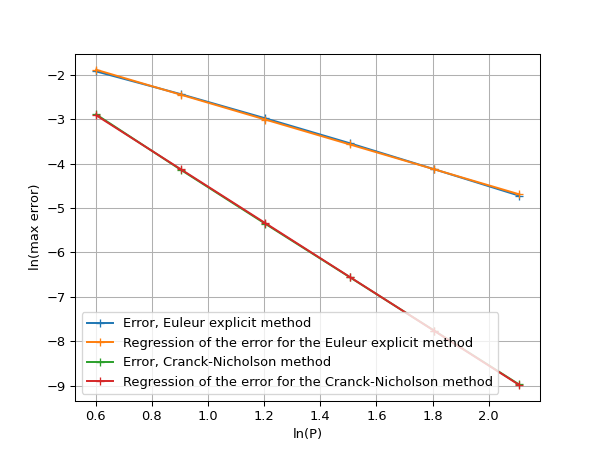

In [47]:
#plt.loglog(Ptab[1:],errtab_imp[1:],label="Euleur explicit method")
#plt.loglog(Ptab[1:],errtab_CN[1:],label="Cranck-Nicholson method")
plt.plot(np.log10(Ptab[1:]),np.log10(errtab_imp[1:]),label="Error, Euleur explicit method", marker="+")
plt.plot(np.log10(Ptab[1:]),alpha_imp*np.log10(Ptab[1:])+beta_imp, label="Regression of the error for the Euleur explicit method",marker="+")
plt.plot(np.log10(Ptab[1:]),np.log10(errtab_CN[1:]),label="Error, Cranck-Nicholson method",marker="+")
plt.plot(np.log10(Ptab[1:]),alpha_CN*np.log10(Ptab[1:])+beta_CN, label="Regression of the error for the Cranck-Nicholson method",marker="+")
plt.xlabel("ln(P)")
plt.ylabel("ln(max error)")
plt.legend()
plt.grid()

In [48]:
plt.close()

$\color{blue}{\textrm{REPONSE 7}\\}$ 
Soit $\epsilon$ l'erreur considérée. A l'aide du script précédent on remarque que le logarithme de l'erreur peut être appproché par une fonction affine du logarithme de P. En effet, les résidus des deux régressions linéaires sont très petits devant 1.

$\begin{equation}
\log(\epsilon)=\alpha \log(P) + \beta \Rightarrow \epsilon = (\frac{T}{\Delta_t})^{\alpha}10^{\beta}
\end{equation}$

In [49]:
print("Pour le schéma d'Euleur explicite, l'erreur décroit en \Delta_t à la puissance", round(-alpha_imp,2))
print("Pour le schéma de Cranck-Nicholson, l'erreur décroit en \Delta_t à la puissance",round(-alpha_CN,2))

Pour le schéma d'Euleur explicite, l'erreur décroit en \Delta_t à la puissance 1.86
Pour le schéma de Cranck-Nicholson, l'erreur décroit en \Delta_t à la puissance 4.03


# III- Etude de l'évolution de l'erreur en fonction de la discrétisation en espace

Dans cette partie, nous étudions l'effet de la discrétisation en espace sur l'approximation donnée par la méthode des éléments finis. 

Nous allons fixer la discrétisation en temps, c'est-à-dire la valeur de $P$ (et donc du pas de temps).

In [50]:
#Valeur de P fixée dans cette partie
P = 100
dt = Deltat(P)

Comme précédemment, nous commençons par fixer une très grande valeur $N_{h_{ref}}$ de référence et nous calculons la solution de référence associée avec un schéma de Cranck-Nicholson. Nous allons supposer que cette solution est suffisamment proche de la solution exacte pour pouvoir la comparer à d'autres solutions calculées pour des valeurs de $N_h$ beaucoup plus faibles que $N_{h_{ref}}$.

1) Remarquez que nous avons ci-dessous choisi $N_{h_{ref}}$ de telle sorte que $h_{ref} = 2^{-K_{ref}}$. Que vaut $K_{ref}$?

$\color{blue}{\textrm{REPONSE 1}\\}$ 
$\begin{equation}
K_{ref}=-\frac{ln(h_{ref})}{ln(2))}
\end{equation}$

In [51]:
#Valeur Nhref de référence et calcul de la solution de la chaleur associée avec un schéma de Cranck-Nicholson
Nhref = 1024 -1
xvec = xgrid(Nhref)

Kref=-np.log(1/(Nhref+1))/np.log(2)
print('K_ref est égal à '+str(Kref))

K_ref est égal à 10.0


Ce calcul de référence peut être assez long. Ne vous étonnez pas si celui-ci prend quelques minutes.

In [52]:
Wref = sol_chaleur(Nhref,P,0.5) 

2) Prouver que pour tout entier $1\leq k \leq K_{ref}$, $V_{2^{-k}} \subset V_{2^{-K_{ref}}}$. Montrer aussi que pour tout $k\in \mathbb{N}^*$,  $N_{2^{-k}} = 2^k -1$.

$\color{blue}{\textrm{REPONSE 2.1}\\}$ 
Montrons que pour tout entier $1\leq k \leq K_{ref}$, $V_{2^{-k}} \subset V_{2^{-K_{ref}}}$

Pour $\Omega=(0,1)$ h représente en fait le pas de discrétisation spatial. D'après l'énoncé, on a en effet $h=\frac{1}{N_h+1}$.

Ainsi $V_{2^{-k}}$ représente la base de discrétisation de l'espace (0,1) en éléments de taille $h=2^{-k}$. De même, $V_{2^{-K_{ref}}}$ est la base de discrétisation de l'espace (0,1) en éléments de taille $h_{ref}=2^{-K_{ref}}$. 

Puisque $k$ et $K_{ref}$ sont des entiers on peut montrer que $h=h_{ref}2^m$ avec $m$ un entier. Donc le pas de discretisation h est $2^m$ fois plus grand que le pas de discrétisation $h_{ref}$ qui est le pas de discretisation plus fin. En d'autres termes, la discrétisation spatiale associée à $h_{ref}$ est obtenue en subdivisant chaque élément de la discrétisation associée à $h$, $2^m$ fois. 

Pour $N_h \in \mathbb{N}^*$, on a $V_h:= {\rm Vect}\left\{ \phi_1^h, \cdots, \phi_{N_h}^h\right\}$

On a donc $V_{2^{-k}} \subset V_{2^{-K_{ref}}}$

$\color{blue}{\textrm{REPONSE 2.2}\\}$ 
Montrons que pour tout $k\in \mathbb{N}^*$,  $N_{2^{-k}} = 2^k -1$.

$\begin{equation} 
h=\frac{1}{N_h+1} \Rightarrow 2^{-k}=\frac{1}{N_{2^{-k}}+1} \Rightarrow N_{2^{-k}} = 2^k -1
\end{equation}$

3) Soit $u\in V_h$ avec $h = 2^{-k}$ pour un certain $1\leq k \leq K_{ref}$, qu'on écrit sous la forme
$$
u = \sum_{i=1}^{N_h} U_i \phi_i^h.
$$
Déduire de la question précédente qu'il existe un vecteur $W = (W_i)_{1\leq i \leq N_{h_{ref}}}$ tel que
$$
u = \sum_{i=1}^{N_{h_{ref}}} W_i \phi_i^{h_{ref}}.
$$
Attention! On ne demande pas de calculer $W$ en fonction de $U = (U_i)_{1\leq i \leq N_h}$! 

$\color{blue}{\textrm{REPONSE 3}\\}$ 

D'après la question précédente, $V_{2^{-k}} \subset V_{2^{-K_{ref}}}$. Ainsi, on peut écrire tout vecteur de $V_h$ comme un vecteur de $V_{2^{-K_{ref}}}$.

Si $u = \sum_{i=1}^{N_h} U_i \phi_i^h$ alors il existe un vecteur $W = (W_i)_{1\leq i \leq N_{h_{ref}}}$ tel que
$u = \sum_{i=1}^{N_{h_{ref}}} W_i \phi_i^{h_{ref}}$.

Le but des lignes de code suivantes est de calculer ce vecteur $W$ en fonction du vecteur $U$. On appellera dans la suite $W$ le vecteur des coordonnées transformées de $U$. 

En fait, de manière plus générale, la fonction suivante transforme un tableau Utab de taille $N_h * k$ en un tableau Wtab de taille $N_{h_{ref}} * k$ de telle sorte que la $j^{eme}$ colonne de Wtab soit le vecteur des coordonnées transformées de la $j^{eme}$ colonne de Utab. 

In [53]:
## Fonction qui transforme un vecteur U de taille Nh = 2^{k}-1 correspondant aux paramètres de discrétisation d'une grille grossière 
## en un vecteur W de taille Nhref = 2^{Kref}-1 correspondant aux paramètres de discrétisation d'une grille fine
## Il faut que Nref + 1 = 2^p * (N+1) pour un certain entier p

## Plus généralement, cette fonction prend un tableau U de taille Nh *k et le transforme en 
## un tableau W de taille Nhref * k.

## Attention! Surtout ne pas modifier cette fonction. 
def convert(Utab):

    K = Utab.shape; 
    k = K[1]; 
    N = K[0];
    M = 2*(N+1);
    Utemp = np.zeros((N+2,k)); 
    Utemp[1:(N+1),:] = Utab; 
    Ntemp = N+1;
    while (M <= (Nhref+1)):
        Wnew = np.zeros((M-1,k)); 
        
        for i in range(0,Ntemp-1):
            Wnew[2*i,:] = 0.5*(Utemp[i,:] + Utemp[i+1,:]); 
            Wnew[2*i+1,:] = Utemp[i+1,:]; 
        Wnew[2*Ntemp-2,:] = 0.5*(Utemp[Ntemp-1,:] + Utemp[Ntemp,:]);

        Utemp = np.zeros((M+1,k)); 
        Utemp[1:M,:] = Wnew; 
        Ntemp = 2*Ntemp; 
        M = 2*M; 

    return Wnew; 

Le but des lignes de code suivantes est de tester cette fonction convert. 

4) Quel test sommes-nous en train d'effectuer dans la cellule de code ci-dessous? Est-ce que le résultat vous semble raisonnable? 

$\color{blue}{\textrm{REPONSE 4}\\}$ 
Dans le code ci-dessous on dispose tout d'abord d'une discretisation de l'espace (0,1) en deux éléments. Notons que l'on pourrait discrétiser l'espace avec un pas plus fin en écrivant Utab=np.zeros(($2^k$-1,1)) avec k un entier. 

Ensuite, la ligne de code Utab[0,0] = 1 permet de dire que la valeur de la solution u est égale à 1 pour $x=\Delta_x=h$, c'est à dire entre le premier et le second élement. 

La ligne de code suivante fait appel à la fonction Wtab. Comme c'est indiqué en commentaire, cette fonction transforme un vecteur U de taille Nh = 2^{k}-1 correspondant aux paramètres de discrétisation d'une grille grossière en un vecteur W de taille Nhref = 2^{Kref}-1 correspondant aux paramètres de discrétisation d'une grille fine.

Les dernières lignes de code ont pour but d'afficher la fonction u sur le nouvel espace de discrétisation. On vérifie ainsi que la solution présente bien l'allure attendue. 

Nombre d'élements initiaux : 2


<IPython.core.display.Javascript object>


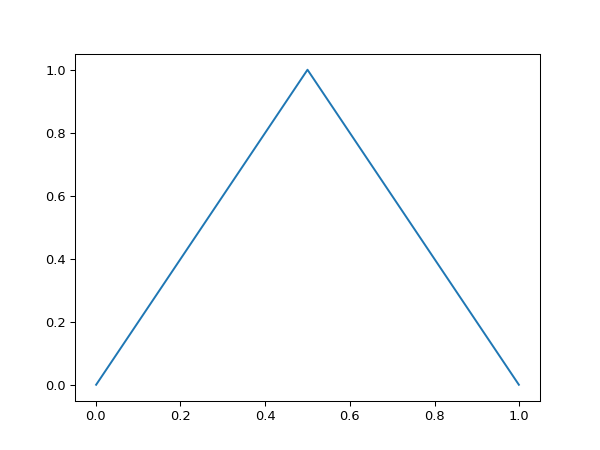

Nombre d'élements finaux : 1024


In [54]:
##Test pour vérifier que la fonction convert fonctionne bien
Utab = np.zeros((1,1))
print("Nombre d'élements initiaux :", len(Utab)+1)
Utab[0,0] = 1
Wtab = convert(Utab)

plt.plot(xvec, Wtab)
plt.show()
print("Nombre d'élements finaux :", len(Wtab)+1)

In [55]:
plt.close()

Dans la suite du code, nous allons tracer l'évolution des erreurs 
$$
\|u_h - u_{h_{ref}}\|_{L^2(]0,T[,H^1_0(0,1))} 
$$
et 
$$
\max_{t\in [0,T]} \|u_h(t) - u_{h_{ref}}(t)\|_{L^2(0,1)}
$$
en fonction de $h$ pour des valeurs de $h$ bien plus grandes que $h_{ref}$, ou du moins une approximation de ces normes. 

Pour cela, une première étape va être de calculer la norme $L^2(0,1)$ et la norme $H^1_0(0,1)$ d'un élement de $V_{h_{ref}}$.  

5) Soit $u\in V_{h_{ref}}$ tel que 
$$
u = \sum_{i=1}^{N_{h_{ref}}} U_i \phi_i^{h_{ref}}.
$$
Montrer que 
$$
\|u \|_{L^2(0,1)}^2 = U^T S_{h_{ref}} U
$$
et que 
$$
\left\|\frac{d}{dx}u\right\|^2_{L^2(0,1)} = U^T K_{h_{ref}}U,
$$
où $U = (U_i)_{1\leq i \leq N_{h_{ref}}}$. 

$\color{blue}{\textrm{REPONSE 5}\\}$ 
Montrons que $ \|u \|_{L^2(0,1)}^2 = U^T S_{h_{ref}} U$ :

$\begin{array}{lcl}
\|u \|_{L^2(0,1)}^2&=& \langle \sum_{i=1}^{N_{h_{ref}}} U_i \phi_i^{h_{ref}}, \sum_{j=1}^{N_{h_{ref}}} U_j \phi_j^{h_{ref}}\rangle_{L^2(0,1)} \\
\|u \|_{L^2(0,1)}^2&=&  \sum_{i=1}^{N_{h_{ref}}}\sum_{j=1}^{N_{h_{ref}}} U_i \langle\phi_i^{h_{ref}},\phi_j^{h_{ref}}\rangle_{L^2(0,1)}   U_j  \\
\|u \|_{L^2(0,1)}^2&=&  U^T S_{h_{ref}} U
\end{array}$

Montrons que $\left\|\frac{d}{dx}u\right\|^2_{L^2(0,1)} = U^T K_{h_{ref}}U$ :

$\begin{array}{lcl}
\left\|\frac{d}{dx}u\right\|^2_{L^2(0,1)}&=& \langle\frac{d}{dx} \sum_{i=1}^{N_{h_{ref}}} U_i \phi_i^{h_{ref}}, \frac{d}{dx}\sum_{j=1}^{N_{h_{ref}}} U_j \phi_j^{h_{ref}}\rangle_{L^2(0,1)} \\
\left\|\frac{d}{dx}u\right\|^2_{L^2(0,1)}&=&  \sum_{i=1}^{N_{h_{ref}}}\sum_{j=1}^{N_{h_{ref}}} U_i \langle\frac{d}{dx}\phi_i^{h_{ref}},\frac{d}{dx}\phi_j^{h_{ref}}\rangle_{L^2(0,1)}   U_j  \\
\left\|\frac{d}{dx}u\right\|^2_{L^2(0,1)}&=&  U^T K_{h_{ref}} U
\end{array}$

Remplir les lignes de code correspondantes dans les cellules ci-dessous.

In [56]:
##Calcule \|u\|_{L^2(0,1)}
# Ici U est un tableau de taille Nhref
def normL2_space(U,Nhref): 
    Shref = Sh(Nhref)
    return np.sqrt(np.dot(np.dot(Shref,U),U))

In [57]:
##Calcule \|d_x u\|_{L^2(0,1)}
# Ici U est un tableau de taille Nhref
def normL2_derivative_space(U,Nhref): 
    Khref = Kh(Nhref)
    return np.sqrt(np.dot(np.dot(Khref,U),U))

Dans la suite, pour une fonction $u\in L^2(]0,T[, V_{h_{ref}})$ suffisamment régulière, nous allons approcher la quantité 
$$
\|u \|_{L^2(]0,T[; L^2(0,1))}^2
$$
par une formule des trapèzes en temps, c'est-à-dire par 
$$
A_1:=\frac{1}{2}\Delta t\|u(t_0)\|_{L^2(0,1)}^2 +  \sum_{p=1}^{P-1} \Delta t \|u(t_p)\|_{L^2(0,1)}^2 + \frac{1}{2}\Delta t\|u(t_P)\|_{L^2(0,1)}^2. 
$$
Le temps initial $t_0=0$ et le temps final $t_P=T$ sont donc pris en compte avec un facteur moitié.

De la même manière, nous allons approcher 
$$
\left\|\frac{d}{dx}u \right\|_{L^2(]0,T[; L^2(0,1))}^2
$$
par 
$$
A_2:=\frac{1}{2}\Delta t \left\|\frac{d}{dx}u(t_0)\right\|_{L^2(0,1)}^2 + \sum_{p=1}^{P-1} \Delta t \left\|\frac{d}{dx}u(t_p)\right\|_{L^2(0,1)}^2 + \frac{1}{2}\Delta t\left\|\frac{d}{dx}u(t_P)\right\|_{L^2(0,1)}^2.
$$
Ainsi, la quantité $\|u \|_{L^2(]0,T[; H_0^1(0,1))}^2$ sera approchée par $A_1+A_2$. 

Remplir l'expression de ces normes en utilisant les fonctions normL2_space et normL2_derivative_space définies précédemment. Attention à ne pas calculer les normes au carré, mais bien les normes! 

In [58]:
##Calcule l'approximation de \|u\|_{L^2(]0,T[,L^2(0,1))}
# Ici U est un tableau de taille Nhref * (P+1)
def normL2_space_time(U,Nhref,P): 
    a10=0.5*dt*normL2_space(U[:,0],Nhref)**2
    a1P=0.5*dt*normL2_space(U[:,P],Nhref)**2
    a1=0
    for k in range (1,P):
        a1+=dt*normL2_space(U[:,k],Nhref)**2 
    return np.sqrt(a10+a1+a1P)

In [59]:
##Calcule l'approximation de \|\d_x u\|_{L^2(]0,T[,L^2(0,1))}
# Ici U est un tableau de taille Nhref * (P+1)
def normL2_derivative_space_time(U,Nhref,P): 
    a20=0.5*dt*normL2_derivative_space(U[:,0],Nhref)**2
    a2P=0.5*dt*normL2_derivative_space(U[:,P],Nhref)**2
    a2=0
    for k in range (1,P):
        a2+=dt*normL2_derivative_space(U[:,k],Nhref)**2 
    return np.sqrt(a20+a2+a2P)


In [60]:
##Calcule l'approximation de \|u\|_{L^2(]0,T[,H^1_0(0,1))}
# Ici U est un tableau de taille Nhref * (P+1)
def normH1_space_time(U,Nhref,P): 
    return np.sqrt(normL2_space_time(U,Nhref,P)**2+normL2_derivative_space_time(U,Nhref,P)**2)

Passons maintenant au calcul de ces erreurs. Nous n'utiliserons ici que le schéma de Cranck-Nicholson pour la discrétisation en temps. Remplir les lignes de code correspondantes.

In [61]:
## Contient les différentes valeurs de Nh pour lesquelles nous allons calculer les erreurs
Nhtab = [2-1,4-1,8-1,16-1,32-1,64-1,128-1, 256-1] 

##Tableaux qui vont contenir les valeurs des différentes erreurs obtenues
## soit max en temps et L^2 en espace
errtab_max_L2_Nh = []

## soit L^2 en temps et H^1_0 en espace
errtab_L2_H10_Nh = []

for Nh in Nhtab:
    U = sol_chaleur(Nh,P,0.5) # contient l'approximation de la solution de la chaleur pour Nh et P 
    
    # convertit les coordonnées de U dans la base des \phi_i^h en ses coordonnées transformées dans la base des \phi_i^{h_{ref}}
    W = convert(U) 
    
    err_max_L2 = 0;
    for p in range(1,P+1):
        
        #Contient l'erreur L^2 en espace à l'instant t_p entre la solution calculée avec Nh et la solution calculée avec Nhref
        err = normL2_space(W[:,p]-Wref[:,p],Nhref)
        err_max_L2 = max(err_max_L2,err);
        
    errtab_max_L2_Nh.append(err_max_L2)
    
    #Contient l'erreur L^2 en temps et H^1_0 en espace entre la solution calculée avec Nh et la solution calculée avec Nhref
    err_L2_H10 = normH1_space_time(W-Wref,Nhref,P) 
        
    errtab_L2_H10_Nh.append(err_L2_H10)

Les lignes de code ci-dessous permettent de tracer ces erreurs en échelle logarithmique en fonction de $N_h$ pour les deux normes choisies ci-dessus. 

Compléter ces lignes de code pour afficher les abscisses, les ordonnées et les labels des différentes courbes tracées.  

In [62]:
plt.loglog(Nhtab,errtab_max_L2_Nh,label="errtab_max_L2_Nh",marker="+")
plt.loglog(Nhtab,errtab_L2_H10_Nh,label="errtab_L2_H10_Nh",marker="+")
plt.legend()
plt.xlabel("$N_h$")
plt.ylabel("$\epsilon$")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

In [63]:
plt.close()

In [65]:
#Regression linéaire pour l'erreur L^2 en espace
#On retire les premiers points car ils ne suivent pas la tendance globale de la courbe.
reg_L2=np.polyfit(np.log10(Nhtab[1:]),np.log10(errtab_max_L2_Nh[1:]),1,rcond=False, full=True)
alpha_L2=reg_L2[0][0]
beta_L2=reg_L2[0][1]
residuals_L2=reg_L2[1][0]
print("alpha_L2=",alpha_L2)
print("beta_L2=",beta_L2)
print("residuals_L2",residuals_L2,'\n')

#Regression linéaire pour l'erreur L^2 en temps et H^1_0 en espace
#On retire les premiers points car ils ne suivent pas la tendance globale de la courbe.
reg_L2_H1=np.polyfit(np.log10(Nhtab[1:]),np.log10(errtab_L2_H10_Nh[1:]),1,rcond=False, full=True)
alpha_L2_H1=reg_L2_H1[0][0]
beta_L2_H1=reg_L2_H1[0][1]
residuals_L2_H1=reg_L2_H1[1][0]
print("alpha_L2_H1=",alpha_L2_H1)
print("beta_L2_H1=",beta_L2_H1)
print("residuals_L2_H1",residuals_L2_H1,'\n')

alpha_L2= -1.8949796728728743
beta_L2= -1.182652751995043
residuals_L2 0.012532414739740207 

alpha_L2_H1= -0.9449184614223167
beta_L2_H1= -0.7586494211484436
residuals_L2_H1 0.004004090331639706 



6) A quelle vitesse en fonction de $h$ décroissent les erreurs
$$
\max_{t\in[0,T]} \|u(t) - u_h(t)\|_{L^2(0,1)}
$$
et 
$$
\| u - u_h \|_{L^2([0,T], H^1_0(0,1))}
$$
(ou plutôt leurs approximations discrétisées en temps)? Si besoin faire une régression linéaire.

$\color{blue}{\textrm{REPONSE 6}\\}$ 
Soit $\epsilon$ l'erreur considérée. A l'aide du script précédent on remarque que le logarithme de l'erreur peut être appproché par une fonction affine du logarithme de P. En effet, les résidus des deux régressions linéaires sont très petits devant 1.

$\begin{equation}
\log(\epsilon)=\alpha \log(N_h) + \beta \Rightarrow \epsilon = N_h^{\alpha}10^{\beta}
\end{equation}$

In [66]:
print("Pour l'erreur L^2 en espace, l'erreur décroit en N_h à la puissance", -round(alpha_L2,2))

print("Pour l'erreur L^2 en temps et H^1_0 en espace, l'erreur décroit en N_h à la puissance", -round(alpha_L2_H1,2))


Pour l'erreur L^2 en espace, l'erreur décroit en N_h à la puissance 1.89
Pour l'erreur L^2 en temps et H^1_0 en espace, l'erreur décroit en N_h à la puissance 0.94


In [69]:
plt.plot(np.log10(Nhtab[1:]),np.log10(errtab_max_L2_Nh[1:]),label="$\epsilon_1$, error max in time and $L^2$ in space", marker="+")
plt.plot(np.log10(Nhtab[1:]),alpha_L2*np.log10(Nhtab[1:])+beta_L2,label="$\epsilon_1$ reg", marker="+")
plt.plot(np.log10(Nhtab[1:]),np.log10(errtab_L2_H10_Nh[1:]),label="$\epsilon_2$, error $L^2$ in time and $H^1_0$ in space",marker="+")
plt.plot(np.log10(Nhtab[1:]),alpha_L2_H1*np.log10(Nhtab[1:])+beta_L2_H1,label="$\epsilon_2$ reg", marker="+")
plt.grid()
plt.xlabel("log$(N_h)$")
plt.ylabel("log$(\epsilon)$")
plt.legend()

<IPython.core.display.Javascript object>

In [70]:
plt.close()

# IV- Méthode Proper Orthogonal Decomposition

Le but de la dernière partie de ce TP est de vous présenter une introduction à la méthode de réduction de modèles appelée Proper Orthogonal Decomposition. 

Celle-ci est typiquement utilisée dans le contexte suivant: imaginez que vous ayez besoin d'approcher numériquement la solution d'une équation de la chaleur dans un milieu hétérogène du type
$$
\left\{
\begin{array}{ll}
\partial_t u(t,x) - \partial_x (c(x) \partial_x u(t,x)) = f(t,x), & \quad (t,x)\in ]0,T[\times (0,1)\\
u(0,x) = g(x), & \quad x\in (0,1),\\
\end{array}
\right.
$$
pour un grand nombre de fonctions $c:(0,1) \to \mathbb{R}$, appelées coefficient de diffusion.

Nous ferons ici l'hypothèse que tous ces coefficients de diffusion vérifieront l'hypothèse qu'il existe $0< \alpha, \beta < +\infty$ tels que 
$$
\alpha \leq c(x) \leq \beta. 
$$
Nous admettrons que sous ces hypothèses, il existe toujours une unique solution faible au problème ci-dessus. 

La méthode POD consiste à:

Etape 1: Résoudre numériquement avec une méthode d'éléments finis (avec une discrétisation spatiale a priori très fine) l'équation ci-dessus pour une valeur du coefficient de diffusion $c_0(x)$ particulière. Dans notre cas, nous prendrons $c_0(x) = 1$, de sorte que le problème ci-dessus sera tout simplement l'équation de la chaleur vue dans les premières parties du TP. Notons $u_0(t,x)$ la solution de cette équation.

Etape 2: Calculer la décomposition en composantes principales (vue dans le DM) de la fonction $u_0(t,x)$. Plus précisément pour une certaine valeur $n\in \mathbb{N}^*$, nous allons calculer $(e_1,\cdots,e_n)\in H^1_0(0,1)$ de telle sorte que 
$$
A_{u_0} e_k = \mu_k e_k
$$
où $A_{u_0}$ est l'opérateur défini dans le DM pour l'espace $V = H^1_0(0,1)$. 

Etape 3: L'équation ci-dessus (avec un coefficient de diffusion $c$ quelconque) est approchée numériquement par une méthode de Galerkin utilisant l'espace de discrétisation $V^n:= {\rm Vect}\{e_1, \cdots, e_n\}$ où les fonctions $e_1, \cdots, e_n$ sont celles qui ont été calculées à l'étape 2 (ou une approximation numérique de celles-ci).

Le but de cette dernière partie du TP est d'étudier numériquement le comportement de cette méthode.

Commençons par la mise en oeuvre de l'étape 1 de la méthode POD. 

Commençons par résoudre l'équation de la chaleur pour une certaine valeur de $N_h$ et $P$. On utilisera toujours ici un schéma de Cranck-Nicholson. 

In [71]:
##Nouvelles valeurs de Nh et P qui seront fixées une fois pour toutes dans la suite
Nh = 299
P = 500

dt = Deltat(P)
dx = Deltax(Nh)

U_0 = sol_chaleur(Nh,P,0.5)

Passons maintenant à l'étape 2 de la méthode POD: nous allons calculer la décomposition en valeurs singulières (approchée) de $u_0(t,x)$ en utilisant la méthode décrite dans votre DM préparatoire. Nous reprenons ici les mêmes notations que dans votre DM et notons, pour tout $n\in \mathbb{N}^*$, $(\mu_n^{app}, E_n^{app})\in \mathbb{R}\times \mathbb{R}^{N_h}$ les solutions du problème aux valeurs propres généralisés
$$
B^{app}E_n^{app} = \mu_n^{app} M E_n^{app}
$$
où les matrices $B^{app}$ et $M$ sont les matrices définies dans la deuxième partie du DM. 

On rappelle que $\mu_n^{app}$ est une approximation de $\mu_n$ la $n^{eme}$ plus grande valeur propre de l'opérateur $A_{u_0}$ et que 
$$
e_n^{app}:= \sum_{i=1}^{N_h} E_{n,i}^{app} \phi_i^h
$$
est une approximation de $e_n$, vecteur propre de $A_{u_0}$ associé à la valeur propre $\mu_n$.  

1) Rappeler l'expression de la matrice $M$ introduite dans le DM. Remplir son expression dans les lignes de code ci-dessous

$\color{blue}{\textrm{REPONSE 1}\\}$ 

La matrice M est définie de la manière suivante : $M=(\langle \phi_i,\phi_j\rangle_{L^2(0,1)})_{1\leq i,j\leq N} $

Donc $M=S_h$


In [72]:
M =  Sh(Nh)

2) Rappeler l'expression de la matrice $C$ introduite dans le DM. Remplir son expression dans les lignes de code ci-dessous. 

$\color{blue}{\textrm{REPONSE 2}\\}$ 
Si on écrit $u(t)=\sum_{i=1}^{N_h}c_i(t)\phi_i$, la colonne p de C donne le vecteur $c(t_p)$. Puisque $U_0$ est la matrice dont la pième colonne est égale à $c(t_p)$ on montre que $U_0=C$.

In [73]:
C=U_0

3) Rappeler l'expression de la matrice $B^{app}$ introduite dans le DM. Remplir son expression dans les lignes de code ci-dessous.

$\color{blue}{\textrm{REPONSE 3}\\}$ 
La matrice $B^{app}$ est définie de la manière suivante : $B^{app}=\Delta_t MC(MC)^T$

In [74]:
B1=np.dot(M,C)
B2=np.transpose(B1)
Bapp=dt*np.dot(B1,B2)

Dans les lignes de code ci-dessous, on calcule la décomposition en composantes principales (approchée) du signal $u_0$. On rappelle que celle-ci est obtenue en résolvant un problème aux valeurs propres généralisés.  

In [75]:
#On calcule la décomposition en composantes principales du signal U_0
print("Calcul de la décomposition en composantes principales du signal U_0")
vals, vecs = LS.eigh(Bapp,M)

Calcul de la décomposition en composantes principales du signal U_0


Les lignes de code suivantes permettent de tracer les valeurs propres $(\mu_n)_{1\leq n \leq N_h}$ en fonction de $n$. Attention! Celles-ci sont automatiquement ordonnées de la valeur la plus petite à la plus grande (donc l'ordre inverse de celui que l'on souhaiterait). Compléter ces lignes de code pour afficher les abscisses, ordonnées et labels. 

<IPython.core.display.Javascript object>


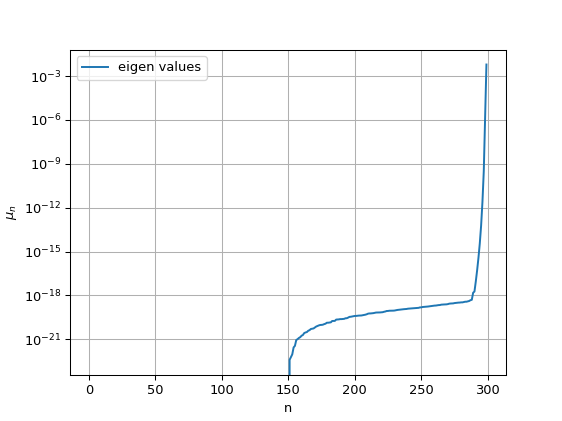

In [76]:
#Vals_rev contient les valeurs propres ordonées dans l'ordre décroissant.
plt.semilogy(np.linspace(1,Nh,Nh), vals, label="eigen values")
plt.ylabel("$\mu_n$")
plt.xlabel("n")
plt.legend()
plt.grid()
plt.show()

In [77]:
plt.close()

4) Qu'observez-vous quant à la vitesse de décroissance des $(\mu_n)_{1\leq n \leq N_h}$? 

$\color{blue}{\textrm{REPONSE 4}\\}$ 
En traçant l'évolution les valeurs propres $(\mu_n)_{1\leq n \leq N_h}$ en fonction de $n$ sur une échelle semilog, on distingue trois comportements :

 -Pour un premier affinement du maillage on observe une croissance rapide du logarithme des valeurs propres en fonction du nombre d'éléments du maillage.
 
 -Pour un second rafinement du maillage, on observe une croissance quasi linéaire où le logarithme des valeurs propres évolue proportionnellement en fonction du nombre d'éléments du maillage.
 
 -Enfin pour un dernier raffinement du maillage, on observe une explosion exponentielle du logarithme des valeurs propres en fonction du nombre d'éléments du maillage. 

Nous pouvons maintenant passer à l'étape 3 de la méthode POD. 

Nous rappelons que pour tout $1\leq n\leq N_h$, on définit
$$
e_n^{app}:= \sum_{i=1}^{N_h} (E_n^{app})_i \phi^h_i.
$$

Nous allons commencer par étudier l'erreur d'approximation d'une méthode de Galerkin associée à l'espace $V^n = {\rm Vect}\{e_1^{app}, \cdots, e_n^{app}\}$ dans le cas où le coefficient de diffusion est égal à $c(x) = c_0(x) = 1$. Mais il faut garder en tête que, dans la méthode POD en pratique, si la valeur du coefficient de diffusion $c(x)$ est modifiée, l'espace de discrétisation reste quant à lui inchangé, ce qui fait qu'on ne calcule la décomposition en composantes principales que d'un seul signal. Cela fera l'objet de la dernière question du TP.

Nous notons dans la suite $u^n$ la solution approchée de l'équation obtenue par l'approximation de Galerkin dans l'espace discrétisé $V^n$. Pour presque tout $t\in [0,T]$, soit $D(t):=(d_1(t), \cdots, d_n(t)) \in \mathbb{R}^n$ les coordonnées de $u^n(t)$ dans la base $(e_1^{app}, \cdots, e_n^{app})$. 

Nous noterons dans la suite, pour une certaine valeur de $1\leq n\leq N_h$, les matrices $K^n:=(K^n_{kl})_{1\leq k,l \leq n},\; S^n:=(S^n_{kl})_{1\leq k,l \leq n} \in \mathbb{R}^{n\times n}$ définies par
$$
S^n_{kl} = \langle e^{app}_k, e^{app}_l \rangle_{L^2(0,1)} \quad \mbox{ et } \quad K_{kl} = \int_0^1 \frac{d}{dx}e_k^{app}(x) \frac{d}{dx}e_l^{app}(x)\,dx.
$$

On note $E^n$ la matrice de taille $N_h \times n$ dont la $k^{eme}$ colonne est donnée par le vecteur $E^{app}_k$. 

5) Montrer que 
$$
S^n = (E^n)^T S_h E^n \quad \mbox{ et } \quad K^n = (E^n)^T K_h E^n.
$$

$\color{blue}{\textrm{REPONSE 5}\\}$
$\color{blue}{\textrm{Calcul de} \  S^n\\}$

Pour tout $1\leq i\leq N_h : (S_hE^n)_i = \sum_{k=1}^{N_h}(S_h)_{ik}(E^n)_{kj}= \sum_{k=1}^{N_h}\langle \phi_i,\phi_k\rangle_{L^2(0,1)} (E_j^{app})_k$

Pour tout $1\leq i,j\leq N_h :$

$\begin{array}{lcl}
((E^n)^T S_h E^n)_{ij}&=&\sum_{k=1}^{N_h}((E^n)^T)_{ik}(S_h E^n)_{kj}\\
((E^n)^T S_h E^n)_{ij}&=&\sum_{k=1}^{N_h}(E^n)_{ki}(S_h E^n)_{kj}\\
((E^n)^T S_h E^n)_{ij}&=&\sum_{k=1}^{N_h}(E_i^{app})_k \sum_{l=1}^{N_h}\langle \phi_k,\phi_l\rangle_{L^2(0,1)} (E_j^{app})_l\\
((E^n)^T S_h E^n)_{ij}&=&\langle\sum_{k=1}^{N_h}(E_i^{app})_k\phi_k,\sum_{l=1}^{N_h}(E_j^{app})_l\phi_l\rangle_{L^2(0,1)}\\
((E^n)^T S_h E^n)_{ij}&=&\langle e_i^{app},e_j^{app}\rangle_{L^2(0,1)}\\
((E^n)^T S_h E^n)_{ij}&=&S^n_{ij} 
\end{array}$

$\color{blue}{\textrm{Calcul de} \  K^n\\}$

Pour tout $1\leq i\leq N_h : (K_hE^n)_i = \sum_{k=1}^{N_h}(K_h)_{ik}(E^n)_{kj}= \sum_{k=1}^{N_h}\int_0^1 \frac{d}{dx}\phi_i^h(x) \frac{d}{dx}\phi_k^h(x)\,dx. (E_j^{app})_k$

Pour tout $1\leq i,j\leq N_h :$

$\begin{array}{lcl}
((E^n)^T K_h E^n)_{ij}&=&\sum_{k=1}^{N_h}((E^n)^T)_{ik}(K_h E^n)_{kj}\\
((E^n)^T S_h E^n)_{ij}&=&\sum_{k=1}^{N_h}(E^n)_{ki}(K_h E^n)_{kj}\\
((E^n)^T S_h E^n)_{ij}&=&\sum_{k=1}^{N_h}(E_i^{app})_k \sum_{l=1}^{N_h}\int_0^1 \frac{d}{dx}\phi_k^h(x) \frac{d}{dx}\phi_l^h(x)\,dx. (E_j^{app})_l  \\
((E^n)^T S_h E^n)_{ij}&=&\int_0^1 \frac{d}{dx}[\sum_{k=1}^{N_h}(E_i^{app})_k \phi_k^h(x)] \frac{d}{dx}[\sum_{l=1}^{N_h}(E_j^{app})_l\phi_l^h(x)]\,dx. \\
((E^n)^T S_h E^n)_{ij}&=&\int_0^1\frac{d}{dx}e_i^{app}(x) \frac{d}{dx}e_j^{app}(x)\,dx.\\
((E^n)^T S_h E^n)_{ij}&=&K^n_{ij} 
\end{array}$

6) Montrer que le vecteur $D(t)$ est solution de l'EDO
$$
S^n \frac{d}{dt}D(t) + K^n D(t) = F^n(t)
$$
où 
$$
F^n(t) = (E^n)^T F_h(t).
$$

$\color{blue}{\textrm{REPONSE 6}\\}$

Soit $1\leq j\leq N_h$, $u^n$ est solution de : $\langle \frac{d}{dt}u^n(t),e_j^{app}\rangle_{L^2(0,1)}+\int_0^1\frac{d}{dx}u^n(t) \frac{d}{dx}e_j^{app}(x)\,dx = \langle f(t),e_j^{app}\rangle_{L^2(0,1)}$

$\begin{array}{lcl}
\langle \frac{d}{dt}u^n(t),e_j^{app}\rangle_{L^2(0,1)}&=&\frac{d}{dt}\langle \sum_i^n d_i(t)e_i^{app} ,e_j^{app}\rangle_{L^2(0,1)}\\
&=&\sum_i^n \langle e_i^{app} ,e_j^{app}\rangle_{L^2(0,1)} \frac{d}{dt} d_i(t) \\
&=&\sum_i^n S^n_{ij}(\frac{d}{dt}D(t))_i\\
&=&\sum_i^n S^n_{ji}(\frac{d}{dt}D(t))_i\\
&=&(S^n\frac{d}{dt}D(t))_j
\end{array}$

$\begin{array}{lcl}
\int_0^1\frac{d}{dx}u^n(t) \frac{d}{dx}e_j^{app}(x)\,dx&=&\int_0^1\frac{d}{dx}\sum_i^n d_i(t)e_i^{app} \frac{d}{dx}e_j^{app}(x)\,dx\\
&=&\sum_i^n\int_0^1\frac{d}{dx}e_i^{app} \frac{d}{dx}e_j^{app} d_i(t)\\
&=&\sum_i K^n_{ji}(D(t))_i\\
&=&(K^nD(t))_j
\end{array}$


$\begin{array}{lcl}
\langle f(t),e_j^{app}\rangle_{L^2(0,1)}&=&\langle f(t),\sum_{i=1}^{N_h} (E_j^{app})_i \phi^h_i.\rangle_{L^2(0,1)} \\
&=&\sum_{i=1}^{N_h} (E_j^{app})_i \langle f(t),\phi^h_i.\rangle_{L^2(0,1)}\\
&=&\sum_{i=1}^{N_h} ((E^n)^T)_{ji} \langle f(t),F_h(t)_i\\
&=&(F^n(t))_j
\end{array}$



Donc le vecteur $D(t)$ est solution de l'EDO $ S^n \frac{d}{dt}D(t) + K^n D(t) = F^n(t)$.

7) Montrer que
$$
F^n(t) = r(t) \overline{F}^n,
$$
où 
$$
\overline{F}^n = (E^n)^T \overline{F}_h.
$$

$\color{blue}{\textrm{REPONSE 7}\\}$

$\begin{array}{lcl}
F^n(t)&=&(E^n)^TF_h(t)\\
F^n(t)&=&(E^n)^T r(t)\overline{F_h}\\
F^n(t)&=&r(t)(E^n)^T \overline{F_h}\\
F^n(t)&=&r(t)\overline{F}^n\\
\end{array}$

8) Ecrire l'expression du $\theta$-schéma associé à un pas de temps $\Delta t>0$ pour résoudre l'EDO dont $D(t)$ est solution. 

$\color{blue}{\textrm{REPONSE 8}\\}$

Soit $p \in \mathbb{N}^*$, notons $D^p$ l'approximation de $D(t_p)$ où $t_p=p\Delta_t>0$. L'expression du $\theta$-schéma dont D(t) est solution est donnée ci-dessous : 

$\begin{equation} 
S_n \frac{D^{p+1}-D^p}{\Delta_t}+K_n(\theta D^{p+1}+(1-\theta)D^p)=\theta F^n(t_{p+1})+(1-\theta)F^n(t_p)
\end{equation}$


$\begin{equation}
(S_n+\theta \Delta t K_n) D^{p+1}=(S_n-(1-\theta) \Delta t K_n) D^{p}+\Delta t\left(\theta F^n\left(t_{p+1}\right)+(1-\theta) F^n\left(t_{p}\right)\right)
\end{equation}$



9) Montrer que $D(0) = 0$.  

$\color{blue}{\textrm{REPONSE 9}\\}$

D'après l'équation de la chaleur et par construction de $u^n$ on montre que $u^n(0)=g=0$.

Or $u^n(0)=\sum_{i=1}^n e_i^{app}d_i(0)=0$. Or la famille $(e_1^{app},...,e_n^{app})$ forme une base donc elle est libre. 

Ainsi, pour tout $1\leq i\leq n, d_i(0)=0$. 

Donc $D(0)=0$.

10) Montrer enfin que pour presque tout $t\in [0,T]$,
$$
u^n(t) = \sum_{i=1}^{N_h} U^n_i(t) \phi^h_i,
$$
où $U^n(t)\in \mathbb{R}^{N_h}$ est donné par
$$
U^n(t) = E^n D(t).
$$

$\color{blue}{\textrm{REPONSE 10}\\}$
$\begin{array}{lcl}
u^n(t)&=&\sum_{j=1}^n d_j(t)e_j^{app}\\
u^n(t)&=&\sum_{j=1}^n d_j(t) \sum_{i=1}^{N_h} (E_j^{app})_i \phi^h_i.\\
u^n(t)&=&\sum_{i=1}^{N_h}  \sum_{j=1}^n (E_j^{app})_i d_j(t)\phi^h_i \\
u^n(t)&=&\sum_{i=1}^{N_h}  \sum_{j=1}^n (E^n)_{ij} (D(t))_j\phi^h_i \\
u^n(t)&=&\sum_{i=1}^{N_h}  (E^nD(t))_i\phi^h_i \\
u^n(t)&=&\sum_{i=1}^{N_h}  U^n_i\phi^h_i \\
\end{array}$

Le but des lignes de code suivantes est d'implémenter un $\theta$-schéma pour résoudre l'EDO dont le vecteur $D(t)$ est solution. Les arguments de la fonction ci-dessous sont $\theta$ et $n$. Remplir les lignes de code correspondantes. Les différentes approximations de $D(t_p)$ pour $0\leq p \leq P$ sont stockées dans un tableau appelé Dtab. La fonction renvoie un tableau Utab dans lequel sont stockées les approximations des vecteurs 
$U^n(t_p) = E^nD(t_p)$.

In [78]:
def sol_chaleur_POD(n,theta):
    
    #En est un tableau de taille Nh * n: la k^eme colonne de En contient le vecteur E^{app}_k
    En = np.zeros((Nh,n)) 
    for k in range(0,n):
        En[:,k] = vecs[:,Nh-k-1]
        
    ##Définition des matrices Sn, Kn, Fbarn    
    Sn = np.dot(En.T,np.dot(Sh(Nh),En))
    Kn = np.dot(np.dot(En.T,Kh(Nh)),En)
    Fbarn = np.dot(En.T,Fbarh(Nh))
    
    ## Dtab va contenir les valeurs de D^p pour tout 0\leq p \leq P
    Dtab = np.zeros((n,P+1));
    
    ## Dold représente la valeur de D^p
    Dold = np.zeros(n)
    Dtab[:,0] = Dold;
    
    for p in range(0,P):
        B = np.dot((Sn-(1-theta)*dt*Kn),Dold)+dt*(theta*Fbarn*r((p+1)*dt)+(1-theta)*Fbarn*r(p*dt))
        A = Sn+theta*dt*Kn
 
        #Dnew représente la valeur de $D^{p+1}
        Dnew = LA.solve(A,B) 
        Dtab[:,p+1] = Dnew 
        Dold = Dnew
       
    # Utab contient les coordonnées des approximations des vecteurs U^n(t_p)
    Utab = np.dot(En, Dtab)
        
    return Utab

Calculons la solution approchée de l'équation de la chaleur par la méthode POD pour $n = 5$ avec un schéma de Cranck-Nicholson. 

In [91]:
Utab = sol_chaleur_POD(5, 0.5)

L'objectif des lignes suivantes est d'afficher une animation pour observer l'évolution de la solution approchée $u^n(t)$.

In [92]:
fig5, ax5 = plt.subplots(1, figsize = (6,6))
xPOD = xgrid(Nh)
plotun,  = ax5.plot(xPOD,Utab[:,0])

def animate5(p):
    f = Utab[:,p]
    plotun.set_ydata(f)    
    
def init5(): 
    ax5.set_xlim(0,1)
    ax5.set_ylim(-0.3,0.3)
    return plotun,

step = 1
steps = np.arange(1,P,step)
ani = FuncAnimation(fig5, animate5,steps, init_func = init5, interval = 100, blit = True)

<IPython.core.display.Javascript object>

In [93]:
plt.close()

11) Est-ce que la solution obtenue par la méthode POD vous semble proche visuellement de la solution de l'équation de la chaleur? Quelle est la dimension de l'espace de discrétisation utilisé ici? Quelle est la valeur de $N_h$? Commentez sur l'intérêt d'utiliser cette méthode POD ici.  

$\color{blue}{\textrm{REPONSE 11}\\}$

La solution obtenue par la méthode POD semble visuellement très proche de la solution de l'équation de la chaleur.

A l'aide du script "Utab = sol_chaleur_POD(5, 0.5)" on génère un tableau de taille ($N_h$,$P+1$) ie de taille (299, 501).

Ici $N_h$ = 299

Nous allons maintenant passer au calcul des erreurs
$$
\|u_h -u^n\|_{L^2(]0,T[, H^1_0(0,1))} 
$$
et 
$$
{\max}_{t\in [0,T]}\|u_h(t) -u^n(t)\|_{L^2(0,1)} .
$$
En utilisant les fonctions définies à la partie 3 du TP, remplir les lignes de code ci-dessous. 

In [82]:
#Tableau qui contient les différentes valeurs de n pour lesquelles la solution approchée par méthode POD va être calculée
ntab = [2,4,6,8,10,15,20,50]

#Tableaux vides qui vont contenir les valeurs des différentes erreurs
#soit max en temps L2 en espace
errtab_max_L2_Nh = []

# soit L2 en temps et H^1_0 en espace
errtab_L2_H10_Nh = []

for n in ntab:
    #Calcul de la solution approchée par méthode POD avec un schéma de Cranck-Nicholson
    Un = sol_chaleur_POD(n,0.5)
 
    err_max_L2 = 0;
    for p in range(1,P+1):
        err = normL2_space(U_0[:,p]-Un[:,p],Nh)
        err_max_L2 = max(err_max_L2,err);
        
    errtab_max_L2_Nh.append(err_max_L2)
    
    
    err_L2_H10 = normH1_space_time(U_0-Un,Nh,P) 
        
    errtab_L2_H10_Nh.append(err_L2_H10)


Les lignes de code ci-dessous permettent de tracer ces erreurs en fonction de $n$. Compléter les abscisses, ordonnées et labels des courbes tracées.

<IPython.core.display.Javascript object>


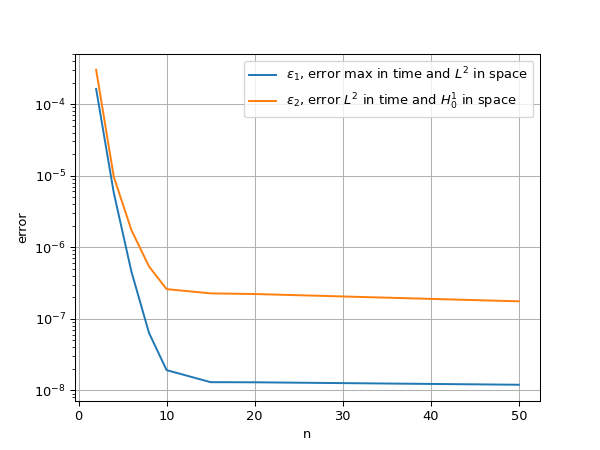

In [83]:
plt.semilogy(ntab,errtab_max_L2_Nh,label="$\epsilon_1$, error max in time and $L^2$ in space")
plt.semilogy(ntab,errtab_L2_H10_Nh, label="$\epsilon_2$, error $L^2$ in time and $H^1_0$ in space")
plt.ylabel("error")
plt.xlabel("n")
plt.legend()
plt.grid()
plt.show()

In [84]:
plt.close()

12) Comment est-ce que ces erreurs évoluent en fonction de $n$? Comparer avec les erreurs et les vitesses obtenues à la partie 3 en fonction de $h$ (ou de $N_h$).

$\color{blue}{\textrm{REPONSE 12}\\}$
On observe que les deux erreurs décroissent d'abord rapidement en fonction de $n$. 
Pour $n\geq 20$ on observe un autre comportement puisque les erreurs décroissent alors très lentement en fonction de $n$. En effet, celles ci semblent quasiment constantes. Notons enfin que l'erreur max en temps et $L^2$ en espace est toujours inférieure à l'erreur $L^2$ en temps et $H^1_0$ en espace.

De plus, on observe que ces erreurs sont bien plus faibles que celle que l'on a obtenues à la partie 3 en fonction de $N_h$. 
Prenons un exemple. Ici pour $n=10$, $\epsilon_1 \simeq 10^{-8}$ et  $\epsilon_2 \simeq 10^{-7}$. Dans la partie 3, pour $n=10$, $\epsilon_1 \simeq 10^{-3}$ et  $\epsilon_2 \simeq 10^{-2}$.


Par ailleurs, en effectuant une regression linéaire sur la partie gauche de chaque courbe, on remarque également que les vitesses de décroissances des erreurs pour la méthode POD sont bien plus élevées que celles obtenues pour la partie 3. 


In [85]:
#Regression linéaire pour l'erreur L^2 en espace
#On retire les derniers points car ils ne nous intéressent pas pour calculer la vitesse de décroissante initiale
reg_L2=np.polyfit(np.log10(ntab[:5]),np.log10(errtab_max_L2_Nh[:5]),1,rcond=False, full=True)
alpha_L2=reg_L2[0][0]
beta_L2=reg_L2[0][1]
residuals_L2=reg_L2[1][0]
print("alpha_L2=",alpha_L2)
print("beta_L2=",beta_L2)
print("residuals_L2",residuals_L2,'\n')

#Regression linéaire pour l'erreur L^2 en temps et H^1_0 en espace
#On retire les derniers points car ils ne nous intéressent pas pour calculer la vitesse de décroissante initiale
reg_L2_H1=np.polyfit(np.log10(ntab[:5]),np.log10(errtab_L2_H10_Nh[:5]),1,rcond=False, full=True)
alpha_L2_H1=reg_L2_H1[0][0]
beta_L2_H1=reg_L2_H1[0][1]
residuals_L2_H1=reg_L2_H1[1][0]
print("alpha_L2_H1=",alpha_L2_H1)
print("beta_L2_H1=",beta_L2_H1)
print("residuals_L2_H1",residuals_L2_H1,'\n')

alpha_L2= -5.7027654422707235
beta_L2= -1.9683841385748617
residuals_L2 0.05048564327879834 

alpha_L2_H1= -4.416231432971872
beta_L2_H1= -2.264205581493301
residuals_L2_H1 0.026268372997144074 



In [86]:
print("Pour l'erreur L^2 en espace, l'erreur décroit en n à la puissance", -round(alpha_L2,2))

print("Pour l'erreur L^2 en temps et H^1_0 en espace, l'erreur décroit en n à la puissance", -round(alpha_L2_H1,2))


Pour l'erreur L^2 en espace, l'erreur décroit en n à la puissance 5.7
Pour l'erreur L^2 en temps et H^1_0 en espace, l'erreur décroit en n à la puissance 4.42


<IPython.core.display.Javascript object>


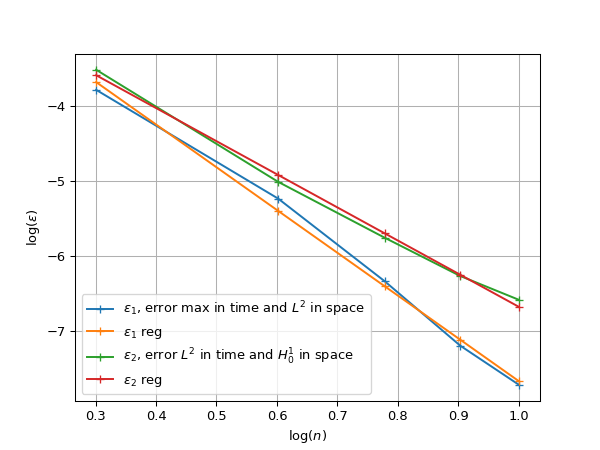

In [87]:
plt.plot(np.log10(ntab[:5]),np.log10(errtab_max_L2_Nh[:5]),label="$\epsilon_1$, error max in time and $L^2$ in space", marker="+")
plt.plot(np.log10(ntab[:5]),alpha_L2*np.log10(ntab[:5])+beta_L2,label="$\epsilon_1$ reg", marker="+")
plt.plot(np.log10(ntab[:5]),np.log10(errtab_L2_H10_Nh[:5]),label="$\epsilon_2$, error $L^2$ in time and $H^1_0$ in space",marker="+")
plt.plot(np.log10(ntab[:5]),alpha_L2_H1*np.log10(ntab[:5])+beta_L2_H1,label="$\epsilon_2$ reg", marker="+")
plt.grid()
plt.xlabel("log$(n)$")
plt.ylabel("log$(\epsilon)$")
plt.legend()

In [88]:
plt.close()

13) (Question facultative) Nous pouvons à présent passer à l'étape 3 de la méthode POD, mais cette fois-ci pour une valeur différente du coefficient de diffusion c(x). 

Implémenter la méthode POD pour approcher la solution de l'équation définie en début de partie pour une valeur du coefficient de diffusion $c(x) = 2$, par une méthode de Galerkin avec l'espace de discrétisation $V^n = {\rm Vect}\{e_1^{app}, \cdots, e_n^{app}\}$. On rappelle que les étapes 1 et 2 de la méthode POD sont indépendantes du choix de $c$, qu'elles ont été faites une bonne fois pour toute (en considérant le coefficient $c_0$), et que seule l'étape 3 de la méthode POD doit être refaite ici.

Calculer et afficher les différents types d'erreur étudiés dans cette partie par rapport à une solution de référence (pour calculer cette solution de référence, on pourra utiliser une approximation de Galerkin de l'équation de la chaleur avec le coefficient c sur un espace d'eléments finis Vh avec un maillage fin).